# Wine Quality Prediction — Deployment-First ML Project


## Project Goal & Deployment Mindset 
**Objective:**  
Build a **binary classification model** to predict whether a wine is *good quality* or *not*, and prepare it for **production deployment**.

**Why this project:**  
- Clean, numeric tabular data  
- Realistic ML use case (quality control)  
- Ideal for REST API–based inference 

## 1. Dataset Description & Source

- Dataset: Wine Quality (Red Wine)  
- Source: UCI Machine Learning Repository  
- Observations: physicochemical tests of wine  
- Features: acidity, alcohol, pH, sulphates, etc.  
- Target (original): `quality` score (0–10)

**Note on Reproducibility:**  
Dataset is public and version-stable. Include dataset download instructions in the repository (e.g., `data/README.md`).


## 2. Problem Framing (Business Perspective)

This is framed as a **binary decision problem**:

> “Given chemical properties of wine, can we automatically flag wines likely to be high quality?”

**Potential real-world applications:**
- Winery quality screening  
- Supply chain quality control  
- Automated decision support


## 3. Experiment Setup

This project uses:
- Fixed random seed  
- Explicit train/validation/test splits 

## 4. Data Loading & Initial Validation

In [1]:
import pandas as pd
def load_red_wine_quality():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    return pd.read_csv(url, sep=";")

df = load_red_wine_quality()

In [2]:
from pathlib import Path

def save_dataframe(
    df: pd.DataFrame,
    data_dir: Path = Path("data"),
    filename: str = "winequality-red.csv",
) -> Path:
    """
    Save a DataFrame to disk, creating the directory if needed.
    Returns the path to the saved file.
    """
    data_dir.mkdir(exist_ok=True)
    local_path = data_dir / filename
    df.to_csv(local_path, index=False)
    return local_path

save_dataframe(df)

WindowsPath('data/winequality-red.csv')

In [3]:
print(df.head().T)
print(df.shape)

                            0        1       2       3        4
fixed acidity          7.4000   7.8000   7.800  11.200   7.4000
volatile acidity       0.7000   0.8800   0.760   0.280   0.7000
citric acid            0.0000   0.0000   0.040   0.560   0.0000
residual sugar         1.9000   2.6000   2.300   1.900   1.9000
chlorides              0.0760   0.0980   0.092   0.075   0.0760
free sulfur dioxide   11.0000  25.0000  15.000  17.000  11.0000
total sulfur dioxide  34.0000  67.0000  54.000  60.000  34.0000
density                0.9978   0.9968   0.997   0.998   0.9978
pH                     3.5100   3.2000   3.260   3.160   3.5100
sulphates              0.5600   0.6800   0.650   0.580   0.5600
alcohol                9.4000   9.8000   9.800   9.800   9.4000
quality                5.0000   5.0000   5.000   6.000   5.0000
(1599, 12)


## 5. EDA and Target Engineering

- Convert multiclass `quality` score into binary target  
- Justify the threshold selection (`>= 7`)  
- Validate resulting class distribution

In [4]:
df["good_quality"] = (df["quality"] >= 7).astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  good_quality          1599 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 162.5 KB
None
----------------------------------------
       fixed acidity  volatil

<Axes: title={'center': 'Good Quality Distribution'}, ylabel='count'>

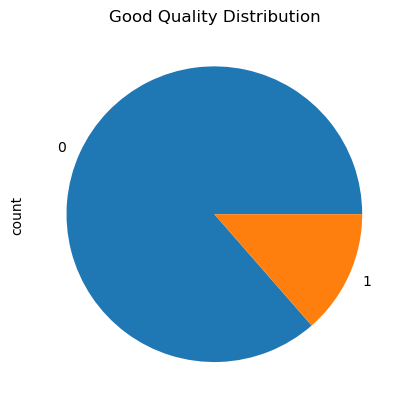

In [5]:
# EDA before split
import matplotlib.pyplot as plt
print(df.info())
print("-" * 40)  
print(df.describe())
#print separator
print("-" * 40) 
#missing values
print('Missing Values:', df.isna().sum())
print("-" * 40)   
print(df["good_quality"].value_counts())

#plot class imbalance
df["good_quality"].value_counts().sort_index().plot.pie(title="Good Quality Distribution")

## 6. Train / Validation / Test Split

**Strategy:**
- Hold out test set (never touched during model selection)  
- Split remaining data into train + validation  
- Use stratification to preserve class balance


In [6]:
# Label encoding

X = df.drop(columns=["quality", "good_quality"])  # <-- NO .columns
y = df["good_quality"]

print(X.shape)   # should be (1599, 11)
print(y.shape)   # should be (1599,)

(1599, 11)
(1599,)


In [7]:
# Train-validation-test split

from sklearn.model_selection import train_test_split

# First split: train + temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Second split: validation + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)  
print(X_test.shape, y_test.shape)  


(1119, 11) (1119,)
(240, 11) (240,)
(240, 11) (240,)


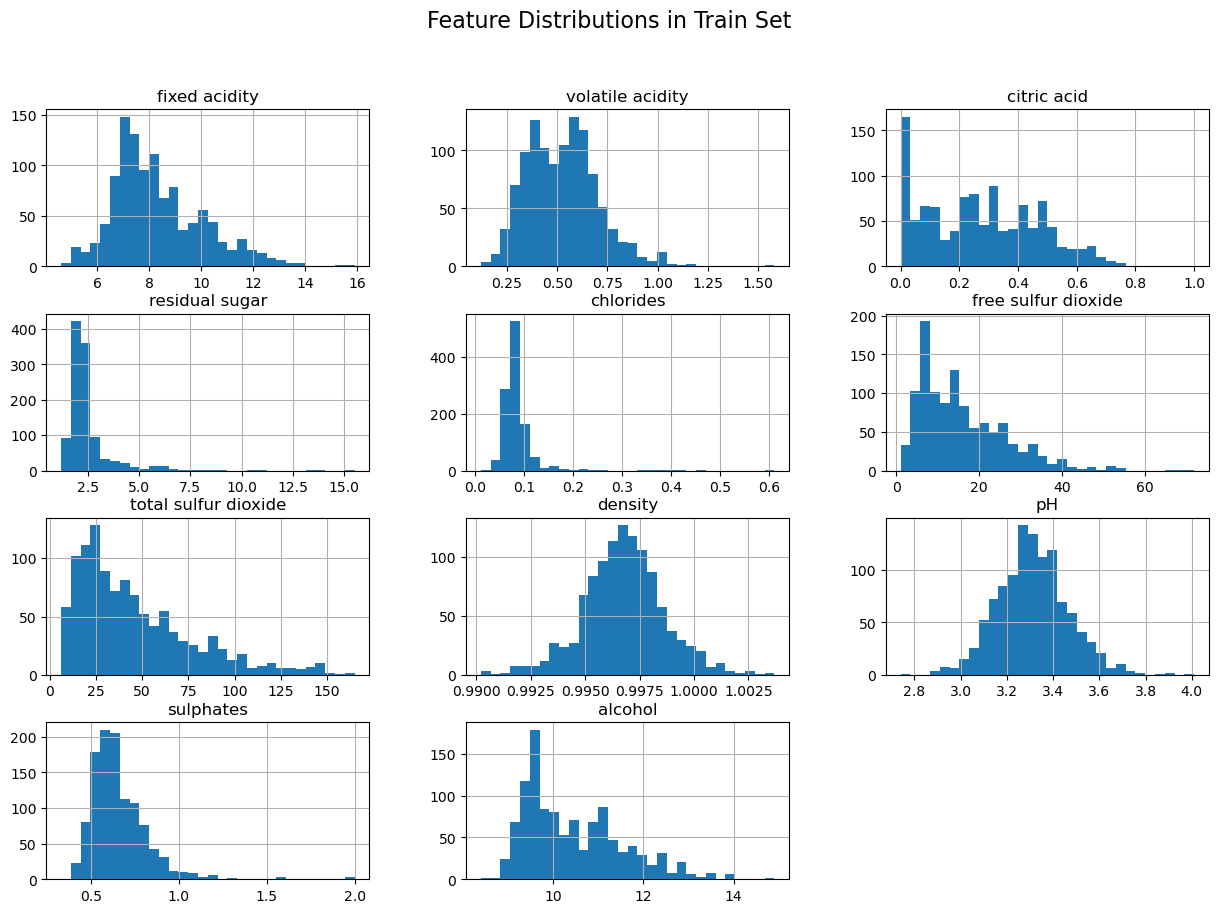

In [8]:
#EDA - AFTER split (train only)
df_eda= pd.concat([X_train, y_train], axis=1)
df_eda.shape

# Feature vs label plots
from matplotlib import pyplot as plt
import seaborn as sns
X_train.hist(bins=30, figsize=(15,10))
plt.suptitle("Feature Distributions in Train Set", fontsize=16)
plt.show()


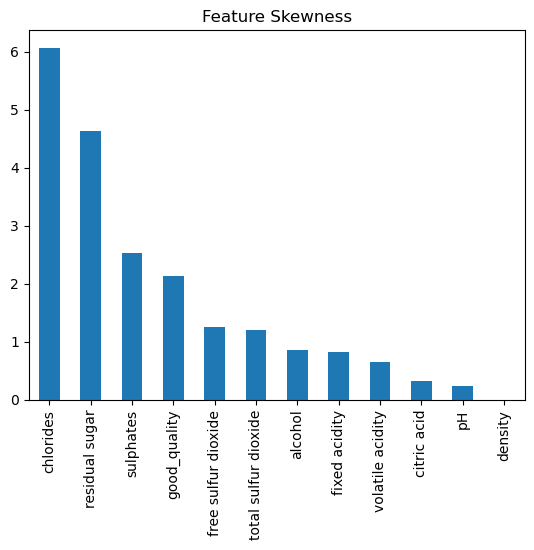

In [9]:
# Skewness analysis
df_eda.skew().sort_values(ascending=False).plot.bar(title="Feature Skewness")
plt.show()

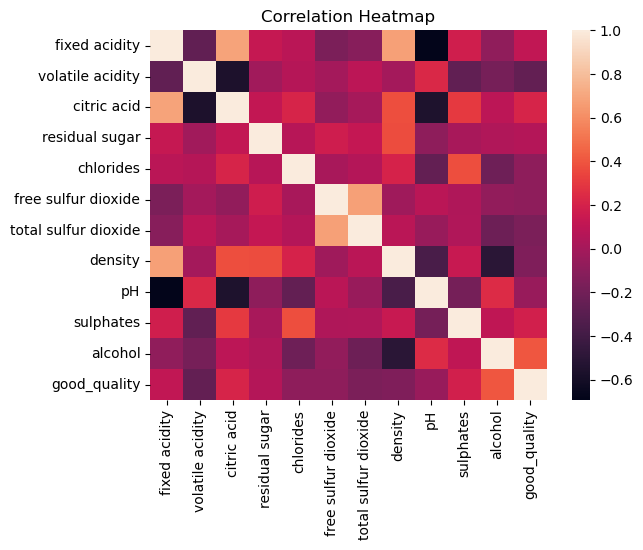

In [10]:
#Correlation analysis
corr = df_eda.corr()
sns.heatmap(corr)
plt.title("Correlation Heatmap")
plt.show()


## Decisions From EDA
1. No features to drop
2. No missing values
3. Use StandardScaler for scaling.

## 7. Baseline Model (Pipeline-First)

**Baseline choice:**
- Logistic Regression  
- StandardScaler  
- Implemented as an sklearn `Pipeline`

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        class_weight="balanced",
        random_state=42
    ))
])
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', random_state=42))])

## 8. Model Evaluation Strategy

Metrics used:
- ROC AUC   
- F1-score 
- Accuracy 

Evaluation performed on:
- Training set  
- Validation set  

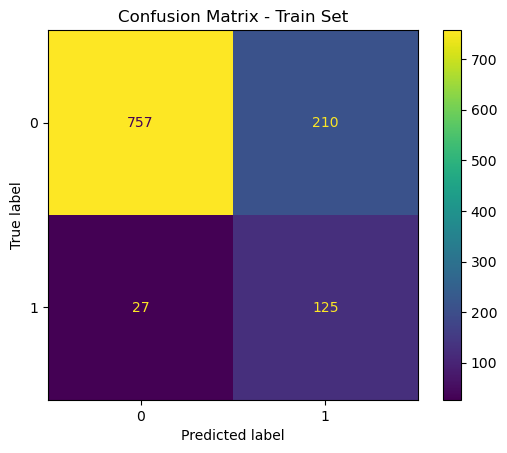

In [12]:
# confustion matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = pipe_lr.predict(X_train)
y_proba = pipe_lr.predict_proba(X_train)[:, 1]
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
plt.title("Confusion Matrix - Train Set")
plt.show()

In [13]:
from sklearn.metrics import classification_report

y_pred = pipe_lr.predict(X_test)
metrics_lr = classification_report(y_test, y_pred)
print(metrics_lr)

              precision    recall  f1-score   support

           0       0.95      0.75      0.84       208
           1       0.31      0.72      0.43        32

    accuracy                           0.75       240
   macro avg       0.63      0.74      0.64       240
weighted avg       0.86      0.75      0.79       240



In [14]:
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score
)

def evaluate(pipe, X, y, threshold=0.5):
    y_prob = pipe.predict_proba(X)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    return {
        "ROC_AUC": roc_auc_score(y, y_prob),
        "F1": f1_score(y, y_pred),
        "Accuracy": accuracy_score(y, y_pred)
    }


In [15]:
# Evaluate on training set
eval_train = evaluate(pipe_lr, X_train, y_train)
eval_train

{'ROC_AUC': np.float64(0.879401839656017),
 'F1': 0.5133470225872689,
 'Accuracy': 0.7882037533512064}

In [16]:
# Evaluate on validation set
val_scores = evaluate(pipe_lr, X_val, y_val, threshold=0.5)
val_scores


{'ROC_AUC': np.float64(0.9472990777338605),
 'F1': 0.6382978723404256,
 'Accuracy': 0.8583333333333333}

In [17]:
# comparison table results of train and val
results = pd.DataFrame([eval_train, val_scores],
                       index=["Train", "Validation"])

results


,ROC_AUC,F1,Accuracy
Train,0.879402,0.513347,0.788204
Validation,0.947299,0.638298,0.858333


In [18]:
# Evaluate on validation set with different thresholds
for t in [0.3, 0.5, 0.7]:
    scores = evaluate(pipe_lr, X_val, y_val, threshold=t)
    print(f"Threshold {t}: {scores}")


Threshold 0.3: {'ROC_AUC': np.float64(0.9472990777338605), 'F1': 0.5546218487394958, 'Accuracy': 0.7791666666666667}
Threshold 0.5: {'ROC_AUC': np.float64(0.9472990777338605), 'F1': 0.6382978723404256, 'Accuracy': 0.8583333333333333}
Threshold 0.7: {'ROC_AUC': np.float64(0.9472990777338605), 'F1': 0.6753246753246753, 'Accuracy': 0.8958333333333334}


In [19]:
from sklearn.metrics import precision_recall_curve

# probabilities
y_prob = pipe_lr.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_prob)


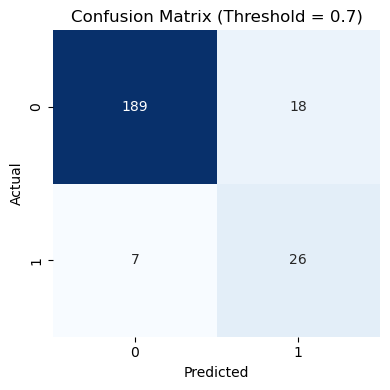

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

threshold = 0.7
y_prob = pipe_lr.predict_proba(X_val)[:, 1]
y_pred = (y_prob >= threshold).astype(int)

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold = 0.7)")
plt.tight_layout()
plt.show()


## 9. Advanced Model
Evaluate one additional model:
- Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier


pipe_rf = Pipeline([
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,              # let trees grow
        min_samples_leaf=5,          # controls overfitting
        class_weight="balanced",     # important for imbalance
        random_state=42,
        n_jobs=-1
    ))
])
pipe_rf.fit(X_train, y_train)   

Pipeline(steps=[('model',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=5, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

In [22]:
# Evaluate Random Forest on train and validation sets
rf_train_scores = evaluate(pipe_rf, X_train, y_train, threshold=0.7)
rf_val_scores   = evaluate(pipe_rf, X_val, y_val, threshold=0.7)

rf_results = pd.DataFrame(
    [rf_train_scores, rf_val_scores],
    index=["Train", "Validation"]
)

rf_results


,ROC_AUC,F1,Accuracy
Train,0.991407,0.810606,0.955317
Validation,0.943493,0.521739,0.908333


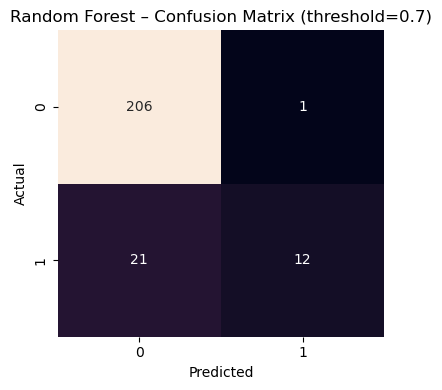

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_prob_rf = pipe_rf.predict_proba(X_val)[:, 1]
y_pred_rf = (y_prob_rf >= 0.7).astype(int)

cm_rf = confusion_matrix(y_val, y_pred_rf)

plt.figure(figsize=(4,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest – Confusion Matrix (threshold=0.7)")
plt.tight_layout()
plt.show()


In [24]:
thr = 0.7
precision, recall, _ = precision_recall_curve(y_val, y_prob_rf)
rows = []
for name, model in [("LogReg", pipe_lr), ("RandomForest", pipe_rf)]:
    rows.append({"Model": name, "Split": "Train", **evaluate(model, X_train, y_train, thr)})
    rows.append({"Model": name, "Split": "Validation", **evaluate(model, X_val, y_val, thr)})

results = pd.DataFrame(rows).set_index(["Model", "Split"])
results


ROC_AUC        F1  Accuracy
Model        Split                                   
LogReg       Train       0.879402  0.541555  0.847185
             Validation  0.947299  0.675325  0.895833
RandomForest Train       0.991407  0.810606  0.955317
             Validation  0.943493  0.521739  0.908333

In [25]:
from sklearn.metrics import precision_score, recall_score

def evaluate(pipe, X, y, threshold=0.7):
    y_prob = pipe.predict_proba(X)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "ROC_AUC": roc_auc_score(y, y_prob),
        "Precision@thr": precision_score(y, y_pred),
        "Recall@thr": recall_score(y, y_pred),
        "F1@thr": f1_score(y, y_pred),
        "Acc@thr": accuracy_score(y, y_pred)
    }


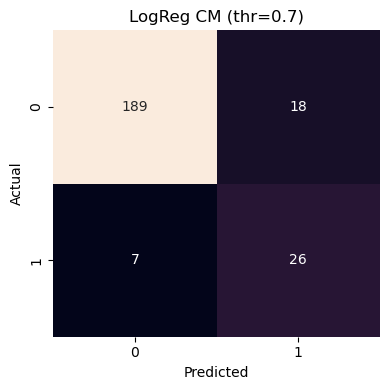

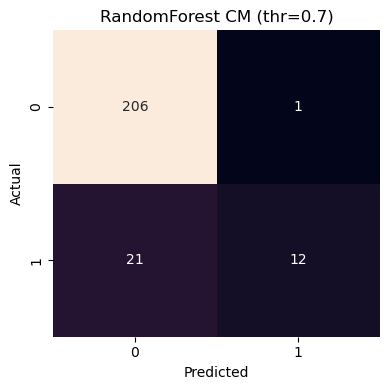

In [26]:

def plot_cm(pipe, X, y, thr, title):
    y_prob = pipe.predict_proba(X)[:, 1]
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

thr = 0.7

#Compare confusion matrices for both models
plot_cm(pipe_lr, X_val, y_val, thr, "LogReg CM (thr=0.7)")
plot_cm(pipe_rf, X_val, y_val, thr, "RandomForest CM (thr=0.7)")


## 10. Model Selection Decision
### Conclusion

- Random Forest shows strong training performance but overfits, leading to reduced validation F1-score.
- Logistic Regression generalizes better, achieving higher validation F1 with comparable ROC-AUC.
- Based on generalization and deployment reliability, Logistic Regression is selected for deployment.




## 11. Final Test Evaluation
**Conclusion'**
### Test Set - Model Performance - Logistic Regression

- The test set is highly imbalanced, with limited positive samples.
- The model achieves high recall for the positive class, indicating effective detection of most true positives.
- Lower precision reflects an expected increase in false positives under the selected threshold.
- Overall performance is consistent with validation results and demonstrates stable generalization.


In [27]:
from sklearn.metrics import classification_report
y_pred_test= pipe_lr.predict(X_test)
metrics_test = classification_report(y_test, y_pred_test)

#Test set classification report using logistic regression
print(metrics_test)

              precision    recall  f1-score   support

           0       0.95      0.75      0.84       208
           1       0.31      0.72      0.43        32

    accuracy                           0.75       240
   macro avg       0.63      0.74      0.64       240
weighted avg       0.86      0.75      0.79       240



## 12. Next Steps (Beyond Notebook)

Planned refactor:
- Convert notebook logic into Python modules 
- Save the model as joblib 
- Build FastAPI service  
- Dockerize inference service  
- Add basic CI using Github Workflow
